In [1]:
%pip install darts

  Using cached darts-0.24.0-py3-none-any.whl (693 kB)
  Using cached catboost-1.2-cp311-cp311-win_amd64.whl (101.0 MB)
  Using cached holidays-0.25-py3-none-any.whl (514 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached lightgbm-3.3.5-py3-none-win_amd64.whl (1.0 MB)
  Using cached matplotlib-3.7.1-cp311-cp311-win_amd64.whl (7.6 MB)
  Using cached nfoursid-1.0.1-py3-none-any.whl (16 kB)
  Using cached pmdarima-2.0.3-cp311-cp311-win_amd64.whl (566 kB)
  Using cached prophet-1.1.3-py3-none-win_amd64.whl (12.1 MB)
  Using cached pyod-1.0.9.tar.gz (149 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached scikit_learn-1.2.2-cp311-cp311-win_amd64.whl (8.3 MB)
  Using cached scipy-1.10.1-cp311-cp311-win_amd64.whl (42.2 MB)
  Using cached shap-0.41.0.tar.gz (380 kB)
  Installing build dependencies: started
  Installing build dependencies: finished wi

  error: subprocess-exited-with-error
  
  × Building wheel for shap (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [119 lines of output]
      The nvcc binary could not be located in your $PATH. Either  add it to your path, or set $CUDAHOME to enable CUDA
      Error building cuda module: TypeError('cannot unpack non-iterable NoneType object')
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\shap
      copying shap\datasets.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\links.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\_explanation.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\_serializable.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\__init__.py -> build\lib.win-amd64-cpython-311\shap
      creating build\lib.win-amd64-cpython-311\shap\explainers
      copying shap\ex

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

import warnings
warnings.filterwarnings('ignore')

from darts.models import (
    DLinearModel,
    NLinearModel
)
from darts.metrics import mape, mae
from pytorch_lightning.callbacks import EarlyStopping
from darts.utils.likelihood_models import QuantileRegression
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_parquet('/content/drive/MyDrive/TimeSeries/Mittelbuenden/train.parquet')
data['Date'] = pd.to_datetime(data['Date'], utc=True)
data.set_index('Date', inplace=True)
# # data = data.resample('H').sum(min_count=1)
# data = data.resample('D').sum(min_count=1)
data=data.sort_index()
data['Covid'] = 0
data['TimeIdx'] = np.arange(len(data))
data.loc[(data.index >= '2020-02-01') & (data.index <= '2021-06-01'), 'Covid'] = 1
TEST_END = '2022-09-01'
TRAIN_END = '2021-09-01'
TRAIN_END = pd.to_datetime(TRAIN_END)
data = data.loc[data.index < TEST_END]
# data['TimeIndex'] = np.arange(len(data))
# data = data.drop(columns=['TimeIndex'])
data

,Consumption,Temperature,Covid,TimeIdx
Date,,,,
2018-01-01 00:00:00+00:00,437079.017331,4.191667,0,0
2018-01-02 00:00:00+00:00,441247.012018,2.158333,0,1
2018-01-03 00:00:00+00:00,428372.492620,2.604167,0,2
2018-01-04 00:00:00+00:00,432217.202020,1.508333,0,3
2018-01-05 00:00:00+00:00,410469.442938,3.991667,0,4
...,...,...,...,...
2022-08-27 00:00:00+00:00,161911.593064,18.858333,0,1699
2022-08-28 00:00:00+00:00,149582.829196,19.729167,0,1700
2022-08-29 00:00:00+00:00,162369.865901,20.904167,0,1701


Data

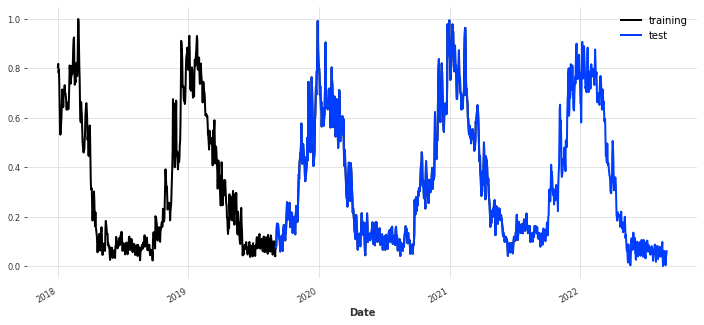

In [ ]:
# from sklearn import preprocessing
# series_scaler = Scaler(scaler=preprocessing.StandardScaler())
series_scaler = Scaler()
series = TimeSeries.from_dataframe(df=data, value_cols='Consumption')
series_unsc = series
series = series_scaler.fit_transform(series)
train, test = series[0:-365], series[-365-730:]
train_unsc, test_unsc = series_unsc[0:-365], series_unsc[-365-730:]
# train, test = series.split_before(TRAIN_END)
# train_unsc, test_unsc = series_unsc.split_before(TRAIN_END)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
test.plot(label='test')
plt.legend()

Covariates

Text(0.5, 1.0, 'Covariates (Covid)')

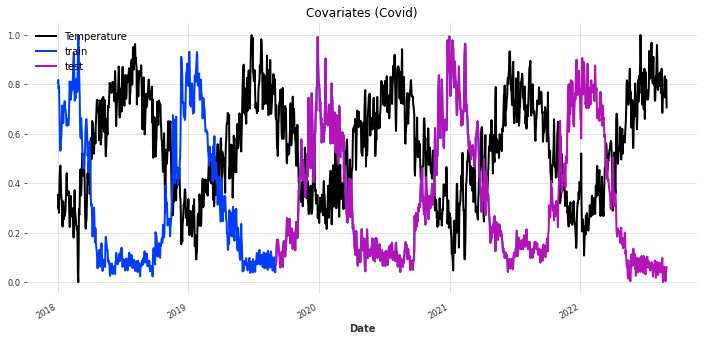

In [ ]:
covid = TimeSeries.from_dataframe(df=data, value_cols='Covid')
covid = covid[1:] # it's somehow longer than the others
year = datetime_attribute_timeseries(series, attribute="year")
month = datetime_attribute_timeseries(series, attribute="month", cyclic=True)
weekday = datetime_attribute_timeseries(series, attribute="weekday", cyclic=True)
dayofyear = datetime_attribute_timeseries(series, attribute="dayofyear", cyclic=True)
temperature = TimeSeries.from_dataframe(df=data, value_cols='Temperature')
timeidx = TimeSeries.from_dataframe(df=data, value_cols='TimeIdx')
# future_scaler = Scaler(scaler=preprocessing.StandardScaler())
future_scaler = Scaler()
# past_scaler = Scaler(scaler=preprocessing.StandardScaler())
past_scaler = Scaler()


### future and past
future_covariates = timeidx.stack(dayofyear).stack(year).stack(month).stack(weekday)#.stack(covid)
past_covariates = temperature
future_covariates =future_scaler.fit_transform(future_covariates)
past_covariates = past_scaler.fit_transform(past_covariates)

### future only
#future_only_covariates = year.stack(month).stack(weekday).stack(covid)
#future_only_covariates = future_only_scaler.fit_transform(future_only_covariates)

### past only
#past_only_covariates = year.stack(month).stack(weekday).stack(covid)
#past_only_covariates = past_only_scaler.fit_transform(past_only_covariates)


plt.figure(101, figsize=(12, 5))
past_covariates.plot()
train.plot(label='train')
test.plot(label='test')
plt.title("Covariates (Covid)")

TFT follow this: https://unit8co.github.io/darts/userguide/hyperparameter_optimization.html?highlight=tuning

In [ ]:
QUANTILES = [0.01, 0.5, 0.99]

model = NLinearModel(
                    input_chunk_length = 32,
                    output_chunk_length = 1,
                    model_name = 'testModel',
                    random_state=16,
                    likelihood=QuantileRegression(quantiles=QUANTILES),
                    lr_scheduler_cls = ReduceLROnPlateau,
                    lr_scheduler_kwargs= {"optimizer": Adam, "threshold": 0.0001, "verbose": True, 'min_lr':1e-6, 'factor':0.5, 'threshold_mode':'abs'},
                    optimizer_kwargs={'lr': 1e-3},
                    batch_size=32,
                    save_checkpoints=True,
                    force_reset=True
                    )

model.fit(series=train,
    future_covariates=future_covariates,
    past_covariates=past_covariates,
    val_series=test,
    val_future_covariates=future_covariates,
    val_past_covariates=past_covariates,
    epochs=100,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type             | Params
----------------------------------------------------
0 | criterion      | MSELoss          | 0     
1 | train_metrics  | MetricCollection | 0     
2 | val_metrics    | MetricCollection | 0     
3 | layer          | Linear           | 963   
4 | linear_fut_cov | Linear           | 27    
----------------------------------------------------
990       Trainable params
0         Non-trainable params
990       Total params
0.008     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00040: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00072: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
best = model.load_from_checkpoint(model_name='testModel', best=True)
scaled_pred_tft = best.predict(n=365, past_covariates=past_covariates, future_covariates=future_covariates, num_samples=100)
pred_tft = series_scaler.inverse_transform(scaled_pred_tft)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAE: 48450.66224286877
MAPE: 22.207804965403483


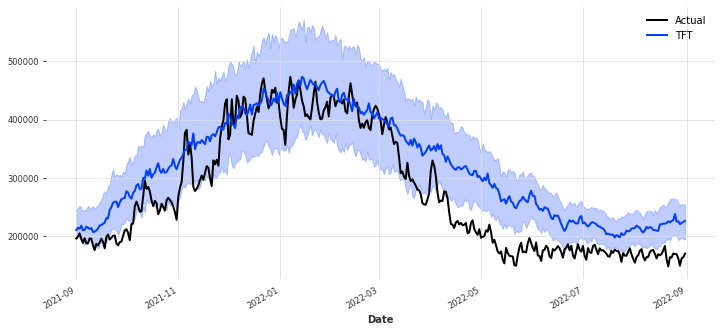

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc[-365:].plot(label='Actual')
pred_tft.plot(label='TFT')
tft_mae = mae(test_unsc[-365:], pred_tft)
tft_mape = mape(test_unsc[-365:], pred_tft)
print(f'MAE: {tft_mae}')
print(f'MAPE: {tft_mape}')

In [ ]:
QUANTILES = [0.01, 0.5, 0.99]

model = DLinearModel(
                    input_chunk_length = 64,
                    output_chunk_length = 1,
                    kernel_size=5,
                    model_name = 'testModel',
                    random_state=16,
                    likelihood=QuantileRegression(quantiles=QUANTILES),
                    lr_scheduler_cls = ReduceLROnPlateau,
                    lr_scheduler_kwargs= {"optimizer": Adam, "threshold": 0.0001, "verbose": True, 'min_lr':1e-6, 'factor':0.5, 'threshold_mode':'abs'},
                    optimizer_kwargs={'lr': 1e-3},
                    batch_size=32,
                    save_checkpoints=True,
                    force_reset=True
                    )

model.fit(series=train,
    future_covariates=future_covariates,
    past_covariates=past_covariates,
    val_series=test,
    val_future_covariates=future_covariates,
    val_past_covariates=past_covariates,
    epochs=150,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 1.9 K 
5 | linear_trend    | Linear           | 1.9 K 
6 | linear_fut_cov  | Linear           | 27    
-----------------------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00041: reducing learning rate of group 0 to 5.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00066: reducing learning rate of group 0 to 2.5000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00082: reducing learning rate of group 0 to 1.2500e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00096: reducing learning rate of group 0 to 6.2500e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00117: reducing learning rate of group 0 to 3.1250e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00128: reducing learning rate of group 0 to 1.5625e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00139: reducing learning rate of group 0 to 7.8125e-06.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 00150: reducing learning rate of group 0 to 3.9063e-06.


In [ ]:
best = model.load_from_checkpoint(model_name='testModel', best=True)
scaled_pred_tft = best.predict(n=365, past_covariates=past_covariates, future_covariates=future_covariates, num_samples=200)
pred_tft = series_scaler.inverse_transform(scaled_pred_tft)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MAE: 22463.844555049633
MAPE: 9.294760372815999


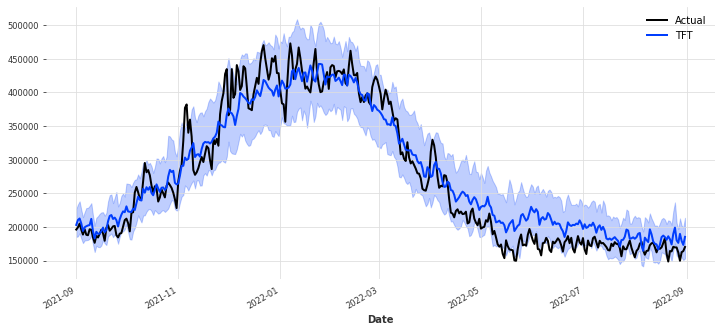

In [ ]:
plt.figure(101, figsize=(12, 5))
test_unsc[-365:].plot(label='Actual')
pred_tft.plot(label='TFT')
tft_mae = mae(test_unsc[-365:], pred_tft)
tft_mape = mape(test_unsc[-365:], pred_tft)
print(f'MAE: {tft_mae}')
print(f'MAPE: {tft_mape}')